# Genetic Algorithm for Neural Network Optimization

---

DQN and PPO are deep reinforcement learning methods that optimize neural network weights through gradient descent, computing how each weight should change to improve performance, then applying small, calculated adjustments through backpropagation. This process requires differentiable loss functions, careful learning rate tuning, and mechanisms like experience replay or policy clipping to remain stable.

A genetic algorithm (GA) approaches the same reinforcement learning problem from a fundamentally different angle. It treats the neural network's weights as a flat array of numbers, called a "genome", and applies principles borrowed from biological evolution to find good values, without ever computing a gradient. While still reinforcement learning (the agent learns from environment interaction and reward signals), it is not deep learning, as the optimization is evolutionary rather than gradient-based.

The process works as follows:

1. **Initialization**: Create a population of 50 random genomes, each representing a complete neural network with random weights.

2. **Evaluation**: Each genome is decoded into a neural network and tested directly in the LunarLander environment. The network receives the same 8 observations (position, velocity, angle, leg contacts) and outputs one of 4 actions, identical to the DQN/PPO networks. Its fitness score is simply the total reward accumulated during the episode.

3. **Selection**: Genomes are ranked by fitness. The top 20% become eligible parents, and the top 3 survive unchanged into the next generation (elitism).

4. **Crossover**: Two parents are selected and their weights are combined to produce a child genome, mixing genetic material from both successful individuals.

5. **Mutation**: Small random perturbations are applied to the child's weights, introducing variation. The mutation rate decays linearly over generations, with large perturbations early for exploration and smaller ones later for refinement.

6. **Repeat**: The new population replaces the old one, and the process repeats for thousands of generations.

The key distinction is what drives learning. In DQN/PPO, the network receives precise mathematical feedback about which direction to adjust each weight. In the GA, there is no such signal. The algorithm only knows "this set of weights scored 280, that one scored 150." It discovers good weights purely through trial, selection, and incremental refinement over generations.

This makes the GA less sample-efficient, requiring roughly 150x more environment interactions than DQN or PPO to reach comparable performance, but also entirely gradient-free. It requires no loss function design, no replay buffer, no policy clipping, and no learning rate schedule. The neural network architecture itself is a simple feedforward network with two hidden layers of 10 neurons each using tanh activations, far smaller than the 256x256 networks used by DQN and PPO, yet sufficient for the task.

In [1]:
import os, sys, random, time
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gymnasium as gym
import imageio.v2 as imageio
from IPython.display import Image, display

In [2]:
# Add src/ to path so we can import the GA modules
SRC_DIR = os.path.join(os.path.dirname(os.path.abspath("__file__")), "src")
if SRC_DIR not in sys.path:
    sys.path.insert(0, SRC_DIR)

from src.evolution.genetic_algorithm import GeneticAlgorithm
from src.evolution.neural_network import NeuralNetwork

In [3]:
# Global Configuration

SEED_LIST = [42, 123, 999]

NOTEBOOK_DIR = os.path.dirname(os.path.abspath("__file__"))
GYMNASIUM_MODEL = "LunarLander-v3"

WIND_ENABLED = False

# GA hyperparameters
INPUT_SIZE = 8
HIDDEN1_SIZE = 10
HIDDEN2_SIZE = 10
OUTPUT_SIZE = 4

POPULATION_SIZE = 50
MUTATION_RATE = 0.05
GENERATIONS = 5000
EVAL_SEEDS_PER_GEN = 3  # seeds used to evaluate each genome during training

# Evaluation
EVALUATION_EPISODES = 20

# Parallelization
MAX_WORKERS = 20

print(f"Seeds: {SEED_LIST}")
print(f"Wind enabled: {WIND_ENABLED}")
print(f"Generations: {GENERATIONS}")
print(f"Population size: {POPULATION_SIZE}")
print(f"Mutation rate: {MUTATION_RATE}")
print(f"Eval seeds per generation: {EVAL_SEEDS_PER_GEN}")
print(f"Evaluation episodes per seed: {EVALUATION_EPISODES}")
print(f"Max workers: {MAX_WORKERS}")

Seeds: [42, 123, 999]
Wind enabled: False
Generations: 5000
Population size: 50
Mutation rate: 0.05
Eval seeds per generation: 3
Evaluation episodes per seed: 20
Max workers: 20


In [4]:
print("Python:", sys.version.split()[0])
print("NumPy:", np.__version__)

Python: 3.12.3
NumPy: 2.4.2


In [5]:
# Environment inspection
env_tmp = gym.make(GYMNASIUM_MODEL)

print("Observation space:", env_tmp.observation_space)
print("Action space:", env_tmp.action_space)

obs, info = env_tmp.reset()
print("Initial observation:", obs)

env_tmp.close()

Observation space: Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
Action space: Discrete(4)
Initial observation: [ 0.00351496  1.4069747   0.35601258 -0.17536424 -0.00406617 -0.08064212
  0.          0.        ]


In [6]:
def set_all_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)


def evaluate_genome_deterministic(genome, n_episodes, seed=None):
    """
    Evaluate a genome deterministically over n_episodes.
    No early termination. Returns list of per-episode rewards.
    """
    nn = NeuralNetwork(INPUT_SIZE, HIDDEN1_SIZE, HIDDEN2_SIZE, OUTPUT_SIZE, genome)
    env = gym.make(GYMNASIUM_MODEL, enable_wind=WIND_ENABLED)
    rewards = []

    for ep in range(n_episodes):
        ep_seed = seed + ep if seed is not None else None
        obs, _ = env.reset(seed=ep_seed)
        total_reward = 0.0
        done = False

        while not done:
            output = nn.forward(obs)
            action = np.argmax(output)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += float(reward)

        rewards.append(total_reward)

    env.close()
    return rewards


def record_genome_gif(genome, seed, output_path):
    """
    Record a single episode GIF of a genome.
    """
    nn = NeuralNetwork(INPUT_SIZE, HIDDEN1_SIZE, HIDDEN2_SIZE, OUTPUT_SIZE, genome)
    env = gym.make(GYMNASIUM_MODEL, render_mode="rgb_array", enable_wind=WIND_ENABLED)
    obs, _ = env.reset(seed=seed)
    frames = []
    done = False

    while not done:
        frames.append(env.render())
        output = nn.forward(obs)
        action = np.argmax(output)
        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

    env.close()
    imageio.mimsave(output_path, frames, fps=30, loop=0)
    return output_path


GA | Seed 42



'Eval @ Gen 5000 | Reward: 255.61 +/- 87.09 [SOLVED] | Success: 85% | Score (mean-std): 168.52 | Best: 270.12'

'Generation 5000 | Best:   282.03 | Avg:   274.94 | Worst:   192.54 | Best Score:   270.12 | Recent Avg(100): 242.1 | MR: 0.0100'

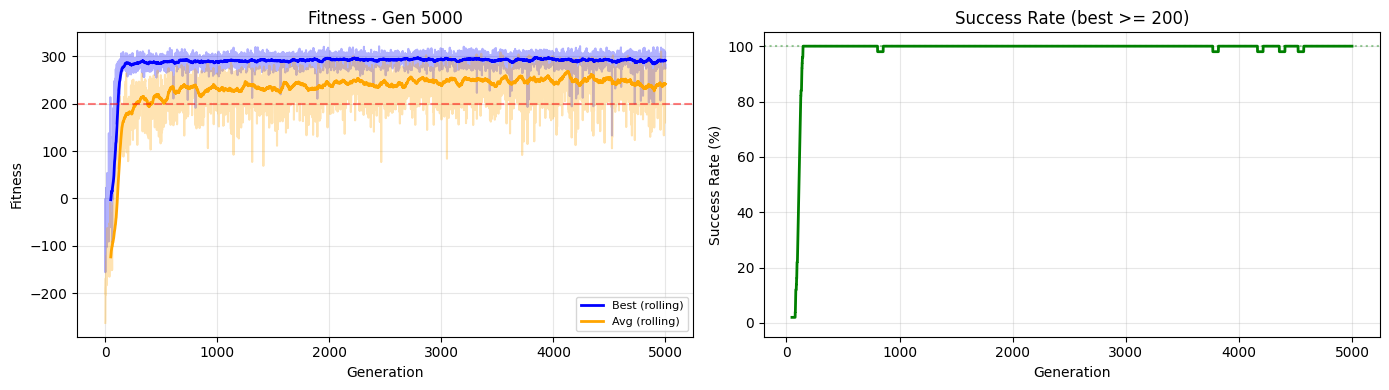


Training time: 18.8 min (1128 s)
Final genome:  /home/logus/env/iscte/taap_p2/genetic/../models/ga/2026-02-21_06_11_43/lab009_ga_42.npy
Best genome:   /home/logus/env/iscte/taap_p2/genetic/../models/ga/2026-02-21_06_11_43/best_genome.npy
Eval log:      /home/logus/env/iscte/taap_p2/genetic/../models/ga/2026-02-21_06_11_43/eval_log
Best genome stats: Reward: 290.64 +/- 20.52 | Success: 100% | Score (mean-std): 270.12 | @ Gen 2000
Estimated env steps: 225,000,000

GA | Seed 123



'Eval @ Gen 5000 | Reward: 280.28 +/- 55.28 [SOLVED] | Success: 95% | Score (mean-std): 225.00 | Best: 290.78'

'Generation 5000 | Best:   302.82 | Avg:   290.24 | Worst:   218.35 | Best Score:   290.78 | Recent Avg(100): 253.3 | MR: 0.0100'

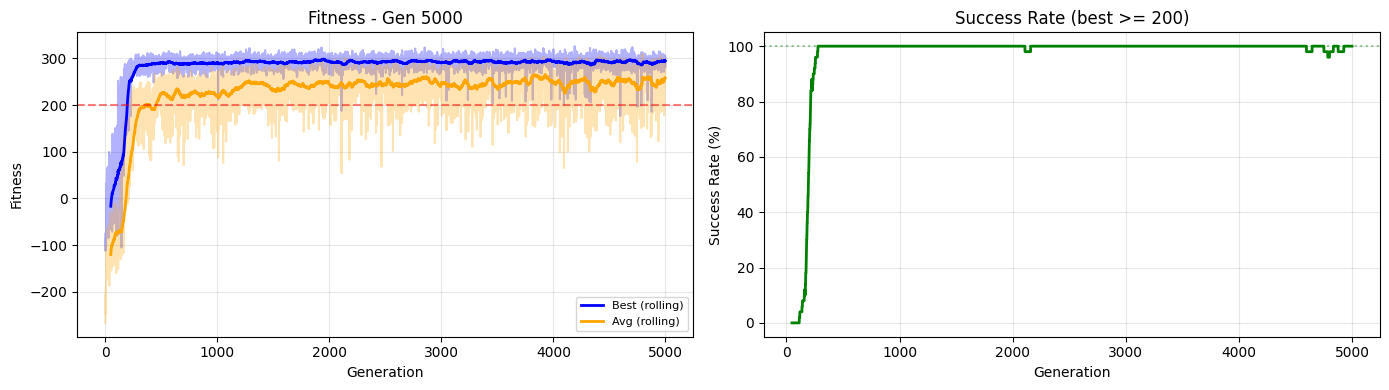


Training time: 23.7 min (1419 s)
Final genome:  /home/logus/env/iscte/taap_p2/genetic/../models/ga/2026-02-21_06_30_31/lab009_ga_123.npy
Best genome:   /home/logus/env/iscte/taap_p2/genetic/../models/ga/2026-02-21_06_30_31/best_genome.npy
Eval log:      /home/logus/env/iscte/taap_p2/genetic/../models/ga/2026-02-21_06_30_31/eval_log
Best genome stats: Reward: 301.73 +/- 10.95 | Success: 100% | Score (mean-std): 290.78 | @ Gen 2100
Estimated env steps: 225,000,000

GA | Seed 999



'Eval @ Gen 5000 | Reward: 213.11 +/- 109.02 [SOLVED] | Success: 75% | Score (mean-std): 104.09 | Best: 269.35'

'Generation 5000 | Best:   267.12 | Avg:   243.19 | Worst:   185.69 | Best Score:   269.35 | Recent Avg(100): 232.7 | MR: 0.0100'

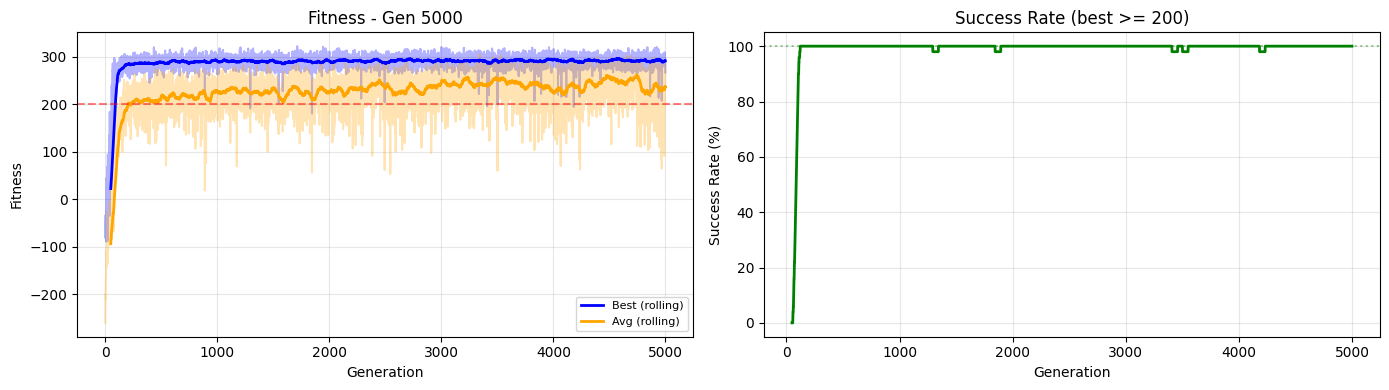


Training time: 29.9 min (1793 s)
Final genome:  /home/logus/env/iscte/taap_p2/genetic/../models/ga/2026-02-21_06_54_10/lab009_ga_999.npy
Best genome:   /home/logus/env/iscte/taap_p2/genetic/../models/ga/2026-02-21_06_54_10/best_genome.npy
Eval log:      /home/logus/env/iscte/taap_p2/genetic/../models/ga/2026-02-21_06_54_10/eval_log
Best genome stats: Reward: 287.12 +/- 17.77 | Success: 100% | Score (mean-std): 269.35 | @ Gen 3800
Estimated env steps: 225,000,000

GA: All 3 seeds trained.

BEST MODEL SUMMARY (all seeds)

 Seed Mean Reward Std Reward Success Score (mean-std)  @ Generation Time (min)
   42      290.64      20.52    100%           270.12          2000       18.8
  123      301.73      10.95    100%           290.78          2100       23.7
  999      287.12      17.77    100%           269.35          3800       29.9


In [7]:
# Training loop: GA x seeds

from IPython.display import display as ipy_display

training_results = {}   # {seed: {"best": [], "avg": [], "worst": []}}
training_times = {}     # {seed: seconds}
best_genomes = {}       # {seed: genome}
best_genome_paths = {}  # {seed: path}
total_env_steps = {}    # {seed: int}
eval_histories = {}     # {seed: list of eval dicts}

CHART_UPDATE_FREQ = 100
EVAL_FREQ_GENS = 100
EVAL_N_EPISODES = 20
SOLVED_THRESHOLD = 200

for seed in SEED_LIST:
    print(f"\n{'='*60}")
    print(f"GA | Seed {seed}")
    print(f"{'='*60}\n")

    # Create timestamped run directory
    run_timestamp = datetime.now().strftime("%Y-%m-%d_%H_%M_%S")
    run_dir = os.path.join(NOTEBOOK_DIR, "../models", "ga", run_timestamp)
    os.makedirs(run_dir, exist_ok=True)

    set_all_seeds(seed)

    ga = GeneticAlgorithm(
        INPUT_SIZE, HIDDEN1_SIZE, HIDDEN2_SIZE, OUTPUT_SIZE,
        POPULATION_SIZE, MUTATION_RATE, render=False, max_workers=MAX_WORKERS,
        generations=GENERATIONS
    )

    best_fitness_history = []
    avg_fitness_history = []
    worst_fitness_history = []
    env_steps = 0
    sorted_population = []

    # Best model tracking (matches DQN/PPO two-tier selection)
    best_combined_score = -np.inf
    best_genome = np.array([])
    best_eval_mean = 0.0
    best_eval_std = np.inf
    best_eval_success = 0.0
    best_gen = 0
    any_solved = False
    eval_history = []

    plot_handle = None
    stats_handle = None
    eval_handle = None

    t_start = time.time()

    for gen in range(GENERATIONS):
        sorted_population = ga.evaluate_population(gen)
        fitness_values = [fitness for _, fitness in sorted_population]
        best_fitness = fitness_values[0]
        worst_fitness = fitness_values[-1]
        avg_fitness = sum(fitness_values) / len(fitness_values)

        best_fitness_history.append(best_fitness)
        avg_fitness_history.append(avg_fitness)
        worst_fitness_history.append(worst_fitness)

        env_steps += POPULATION_SIZE * EVAL_SEEDS_PER_GEN * 300

        # Periodic deterministic evaluation of generation's best genome
        if (gen + 1) % EVAL_FREQ_GENS == 0:
            candidate_genome = sorted_population[0][0]
            eval_rewards = evaluate_genome_deterministic(
                candidate_genome, EVAL_N_EPISODES, seed=seed
            )
            eval_mean = np.mean(eval_rewards)
            eval_std = np.std(eval_rewards)
            eval_success = np.sum(np.array(eval_rewards) >= SOLVED_THRESHOLD) / len(eval_rewards) * 100
            combined_score = eval_mean - eval_std
            is_solved = eval_mean >= SOLVED_THRESHOLD

            eval_history.append({
                "generation": gen + 1,
                "mean": eval_mean,
                "std": eval_std,
                "success": eval_success,
                "score": combined_score,
                "solved": is_solved,
            })

            # Two-tier best model selection (matches DQN/PPO logic)
            save_new_best = False
            if is_solved:
                if not any_solved:
                    save_new_best = True
                    any_solved = True
                elif combined_score > best_combined_score:
                    save_new_best = True
            elif not any_solved:
                if combined_score > best_combined_score:
                    save_new_best = True

            solved_tag = " [SOLVED]" if is_solved else ""
            eval_text = (
                f"Eval @ Gen {gen + 1} | "
                f"Reward: {eval_mean:.2f} +/- {eval_std:.2f}{solved_tag} | "
                f"Success: {eval_success:.0f}% | "
                f"Score (mean-std): {combined_score:.2f} | "
                f"Best: {best_combined_score:.2f}"
            )

            if save_new_best:
                eval_text += " >> New best genome!"
                best_combined_score = combined_score
                best_eval_mean = eval_mean
                best_eval_std = eval_std
                best_eval_success = eval_success
                best_gen = gen + 1
                best_genome = candidate_genome.copy()
                np.save(os.path.join(run_dir, "best_genome.npy"), best_genome)

            if eval_handle is None:
                eval_handle = ipy_display(eval_text, display_id=True)
            else:
                eval_handle.update(eval_text)

        if (gen + 1) % CHART_UPDATE_FREQ == 0:
            recent_avg = np.mean(avg_fitness_history[-100:])
            stats_text = (
                f"Generation {gen + 1} | "
                f"Best: {best_fitness:>8.2f} | "
                f"Avg: {avg_fitness:>8.2f} | "
                f"Worst: {worst_fitness:>8.2f} | "
                f"Best Score: {best_combined_score:>8.2f} | "
                f"Recent Avg(100): {recent_avg:.1f} | "
                f"MR: {ga.mutation_rate:.4f}"
            )
            if stats_handle is None:
                stats_handle = ipy_display(stats_text, display_id=True)
            else:
                stats_handle.update(stats_text)

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

            ax1.plot(best_fitness_history, alpha=0.3, color='blue')
            ax1.plot(avg_fitness_history, alpha=0.3, color='orange')
            window = min(50, len(best_fitness_history))
            rolling_best = pd.Series(best_fitness_history).rolling(window).mean()
            rolling_avg = pd.Series(avg_fitness_history).rolling(window).mean()
            ax1.plot(rolling_best, color='blue', linewidth=2, label='Best (rolling)')
            ax1.plot(rolling_avg, color='orange', linewidth=2, label='Avg (rolling)')
            ax1.axhline(y=200, color='red', linestyle='--', alpha=0.5)
            ax1.set_title(f"Fitness - Gen {gen + 1}")
            ax1.set_xlabel("Generation")
            ax1.set_ylabel("Fitness")
            ax1.legend(fontsize=8)
            ax1.grid(True, alpha=0.3)

            success = np.array(best_fitness_history) >= 200
            rolling_success = pd.Series(success.astype(float)).rolling(window).mean() * 100
            ax2.plot(rolling_success, color='green', linewidth=2)
            ax2.axhline(y=100, color='green', linestyle=':', alpha=0.4)
            ax2.set_title(f"Success Rate (best >= 200)")
            ax2.set_xlabel("Generation")
            ax2.set_ylabel("Success Rate (%)")
            ax2.set_ylim(-5, 105)
            ax2.grid(True, alpha=0.3)

            plt.tight_layout()

            if plot_handle is None:
                plot_handle = ipy_display(fig, display_id=True)
            else:
                plot_handle.update(fig)
            plt.close(fig)

        ga.next_generation(sorted_population)

    t_elapsed = time.time() - t_start

    # Save final genome (best of last generation)
    final_genome = sorted_population[0][0]
    final_path = os.path.join(run_dir, f"lab009_ga_{seed}.npy")
    np.save(final_path, final_genome)

    # Save eval log (matches DQN/PPO evaluations.npz format)
    eval_log_dir = os.path.join(run_dir, "eval_log")
    os.makedirs(eval_log_dir, exist_ok=True)
    if eval_history:
        np.savez(
            os.path.join(eval_log_dir, "evaluations"),
            generations=np.array([e["generation"] for e in eval_history]),
            means=np.array([e["mean"] for e in eval_history]),
            stds=np.array([e["std"] for e in eval_history]),
            scores=np.array([e["score"] for e in eval_history]),
            success_rates=np.array([e["success"] for e in eval_history]),
        )

    # Save fitness history
    history_path = os.path.join(run_dir, f"fitness_history_seed{seed}.npz")
    np.savez(history_path,
             best=best_fitness_history,
             avg=avg_fitness_history,
             worst=worst_fitness_history)

    training_results[seed] = {
        "best": best_fitness_history,
        "avg": avg_fitness_history,
        "worst": worst_fitness_history,
    }
    training_times[seed] = t_elapsed
    best_genomes[seed] = best_genome
    best_genome_paths[seed] = {
        "run_dir": run_dir,
        "final": final_path,
        "best": os.path.join(run_dir, "best_genome.npy"),
    }
    total_env_steps[seed] = env_steps
    eval_histories[seed] = eval_history

    print(f"\nTraining time: {t_elapsed/60:.1f} min ({t_elapsed:.0f} s)")
    print(f"Final genome:  {final_path}")
    print(f"Best genome:   {os.path.join(run_dir, 'best_genome.npy')}")
    print(f"Eval log:      {eval_log_dir}")
    print(
        f"Best genome stats: "
        f"Reward: {best_eval_mean:.2f} +/- {best_eval_std:.2f} | "
        f"Success: {best_eval_success:.0f}% | "
        f"Score (mean-std): {best_combined_score:.2f} | "
        f"@ Gen {best_gen}"
    )
    print(f"Estimated env steps: {env_steps:,}")

print(f"\nGA: All {len(SEED_LIST)} seeds trained.")

# Training Summary Table
print(f"\n{'='*60}")
print("BEST MODEL SUMMARY (all seeds)")
print(f"{'='*60}\n")

rows = []
for seed in SEED_LIST:
    # Find the best eval entry for this seed
    best_eval = max(eval_histories[seed], key=lambda x: x["score"])
    rows.append({
        "Seed": seed,
        "Mean Reward": f"{best_eval['mean']:.2f}",
        "Std Reward": f"{best_eval['std']:.2f}",
        "Success": f"{best_eval['success']:.0f}%",
        "Score (mean-std)": f"{best_eval['score']:.2f}",
        "@ Generation": best_eval["generation"],
        "Time (min)": f"{training_times[seed]/60:.1f}",
    })

print(pd.DataFrame(rows).to_string(index=False))

In [8]:
# Training Time Summary

rows = []
for seed in SEED_LIST:
    t = training_times[seed]
    rows.append({
        "Algorithm": "GA",
        "Seed": seed,
        "Time (s)": f"{t:.0f}",
        "Time (min)": f"{t/60:.1f}",
    })

times = list(training_times.values())
rows.append({
    "Algorithm": "GA",
    "Seed": "Mean",
    "Time (s)": f"{np.mean(times):.0f}",
    "Time (min)": f"{np.mean(times)/60:.1f}",
})

print("*** TRAINING TIME SUMMARY ***")
print(f"Generations: {GENERATIONS} | Population: {POPULATION_SIZE} | Workers: {MAX_WORKERS}")
print()
print(pd.DataFrame(rows).to_string(index=False))

*** TRAINING TIME SUMMARY ***
Generations: 5000 | Population: 50 | Workers: 20

Algorithm Seed Time (s) Time (min)
       GA   42     1128       18.8
       GA  123     1419       23.7
       GA  999     1793       29.9
       GA Mean     1447       24.1


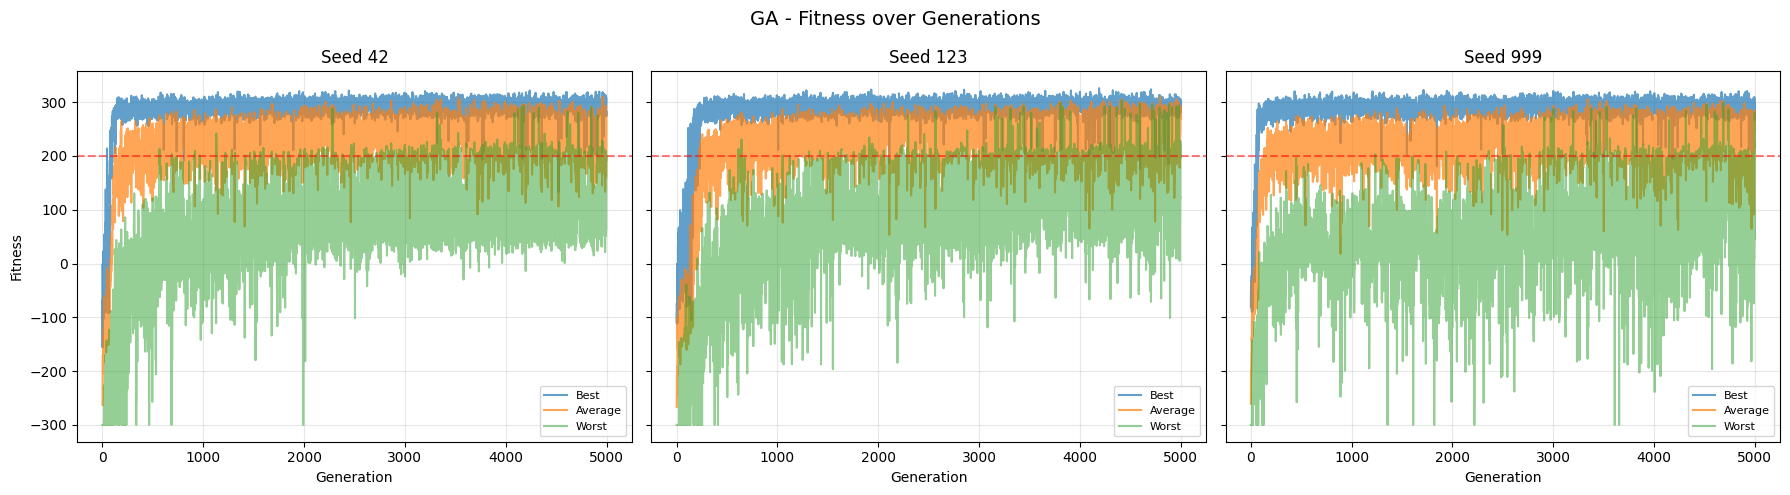

In [9]:
# Per-Seed: Fitness over Generations

fig, axes = plt.subplots(1, len(SEED_LIST), figsize=(6 * len(SEED_LIST), 5), sharey=True)
if len(SEED_LIST) == 1:
    axes = [axes]

for ax, seed in zip(axes, SEED_LIST):
    ax.plot(training_results[seed]["best"], alpha=0.7, label="Best")
    ax.plot(training_results[seed]["avg"], alpha=0.7, label="Average")
    ax.plot(training_results[seed]["worst"], alpha=0.5, label="Worst")
    ax.axhline(y=200, color='red', linestyle='--', alpha=0.5)
    ax.set_title(f"Seed {seed}")
    ax.set_xlabel("Generation")
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)

axes[0].set_ylabel("Fitness")
fig.suptitle("GA - Fitness over Generations", fontsize=14)
plt.tight_layout()
plt.show()

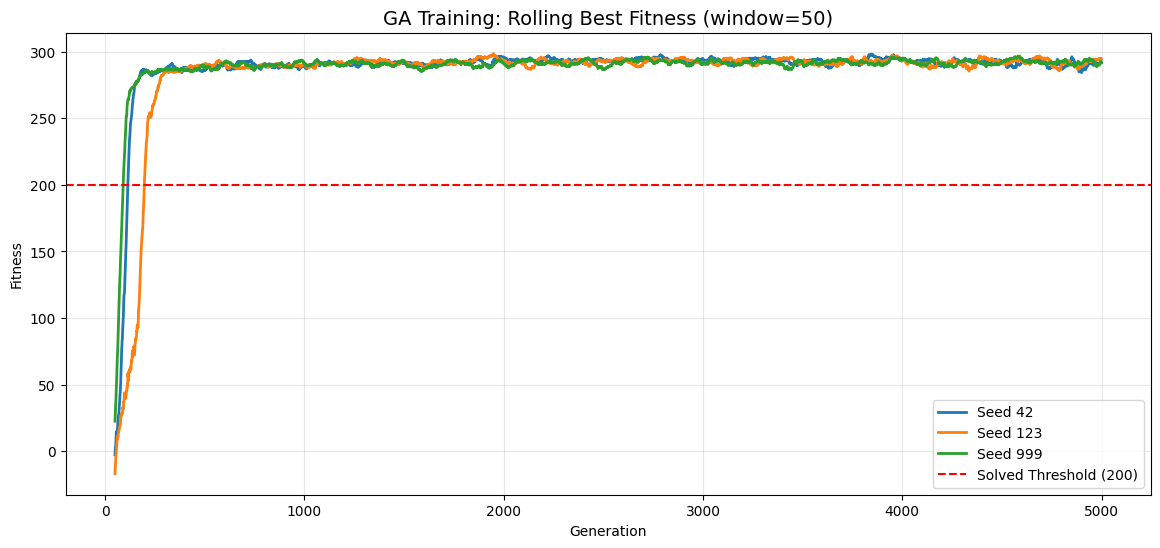

In [10]:
# Aggregated: Rolling Best Fitness Overlay (all seeds on one chart)

seed_colors = list(plt.colormaps["tab10"](range(10)))

plt.figure(figsize=(14, 6))
for i, seed in enumerate(SEED_LIST):
    rolling = pd.Series(training_results[seed]["best"]).rolling(50).mean()
    plt.plot(rolling, color=seed_colors[i], linewidth=2, label=f"Seed {seed}")

plt.axhline(y=200, color='red', linestyle='--', label='Solved Threshold (200)')
plt.title("GA Training: Rolling Best Fitness (window=50)", fontsize=14)
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

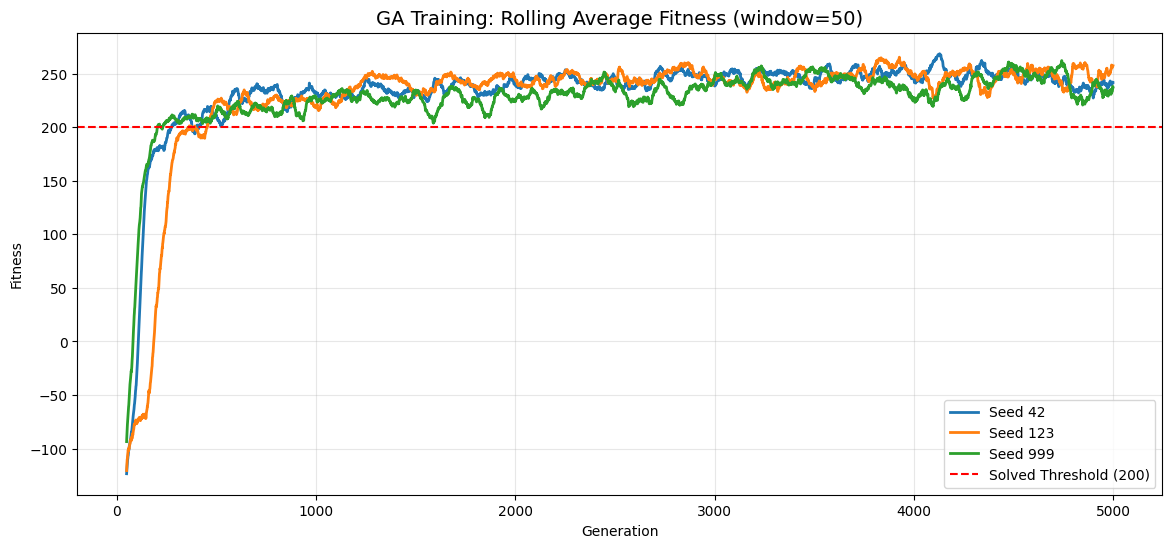

In [11]:
# Aggregated: Rolling Average Fitness Overlay (all seeds on one chart)

plt.figure(figsize=(14, 6))
for i, seed in enumerate(SEED_LIST):
    rolling = pd.Series(training_results[seed]["avg"]).rolling(50).mean()
    plt.plot(rolling, color=seed_colors[i], linewidth=2, label=f"Seed {seed}")

plt.axhline(y=200, color='red', linestyle='--', label='Solved Threshold (200)')
plt.title("GA Training: Rolling Average Fitness (window=50)", fontsize=14)
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

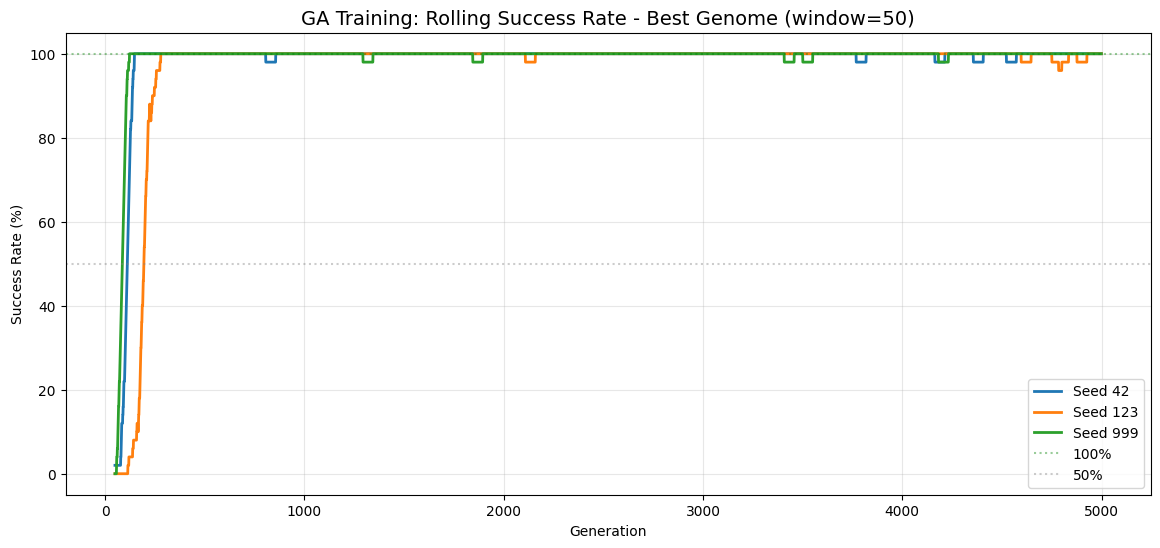

In [12]:
# Rolling Success Rate over Training (best fitness >= 200)

plt.figure(figsize=(14, 6))
for i, seed in enumerate(SEED_LIST):
    success = np.array(training_results[seed]["best"]) >= 200
    rolling_success = pd.Series(success.astype(float)).rolling(50).mean() * 100
    plt.plot(rolling_success, color=seed_colors[i], linewidth=2, label=f"Seed {seed}")

plt.axhline(y=100, color='green', linestyle=':', alpha=0.4, label='100%')
plt.axhline(y=50, color='gray', linestyle=':', alpha=0.4, label='50%')
plt.title("GA Training: Rolling Success Rate - Best Genome (window=50)", fontsize=14)
plt.xlabel("Generation")
plt.ylabel("Success Rate (%)")
plt.ylim(-5, 105)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [13]:
# Evaluation: deterministic episodes per seed (best genome)

evaluation_results = {}  # {seed: np.array}

for seed in SEED_LIST:
    print(f"Evaluating GA seed {seed} (best genome)...")

    set_all_seeds(seed)
    genome = best_genomes[seed]

    rewards = evaluate_genome_deterministic(genome, EVALUATION_EPISODES, seed=seed)
    evaluation_results[seed] = np.array(rewards)

    mean_r = np.mean(rewards)
    std_r = np.std(rewards)
    success = np.sum(np.array(rewards) >= 200) / len(rewards) * 100
    print(f"  Reward: {mean_r:.2f} +/- {std_r:.2f} | Success: {success:.0f}%")

print(f"\nEvaluation complete for all seeds.")

Evaluating GA seed 42 (best genome)...
  Reward: 290.64 +/- 20.52 | Success: 100%
Evaluating GA seed 123 (best genome)...
  Reward: 301.73 +/- 10.95 | Success: 100%
Evaluating GA seed 999 (best genome)...
  Reward: 287.12 +/- 17.77 | Success: 100%

Evaluation complete for all seeds.


In [14]:
# Evaluation Summary Table

rows = []
for seed in SEED_LIST:
    r = evaluation_results[seed]
    rows.append({
        "Seed": seed,
        "Mean Reward": f"{np.mean(r):.2f}",
        "Std Dev": f"{np.std(r):.2f}",
        "Min Reward": f"{np.min(r):.2f}",
        "Max Reward": f"{np.max(r):.2f}",
        "Success Rate": f"{(r >= 200).sum() / len(r) * 100:.1f}%"
    })

all_r = np.concatenate([evaluation_results[s] for s in SEED_LIST])
rows.append({
    "Seed": "Overall",
    "Mean Reward": f"{np.mean(all_r):.2f}",
    "Std Dev": f"{np.std(all_r):.2f}",
    "Min Reward": f"{np.min(all_r):.2f}",
    "Max Reward": f"{np.max(all_r):.2f}",
    "Success Rate": f"{(all_r >= 200).sum() / len(all_r) * 100:.1f}%"
})

print(f"*** GA MULTI-SEED EVALUATION SUMMARY ***")
print(f"Episodes per seed: {EVALUATION_EPISODES} | Total: {len(all_r)}")
print(pd.DataFrame(rows).to_string(index=False))

*** GA MULTI-SEED EVALUATION SUMMARY ***
Episodes per seed: 20 | Total: 60
   Seed Mean Reward Std Dev Min Reward Max Reward Success Rate
     42      290.64   20.52     258.55     321.98       100.0%
    123      301.73   10.95     284.02     319.78       100.0%
    999      287.12   17.77     254.22     320.95       100.0%
Overall      293.16   18.01     254.22     321.98       100.0%


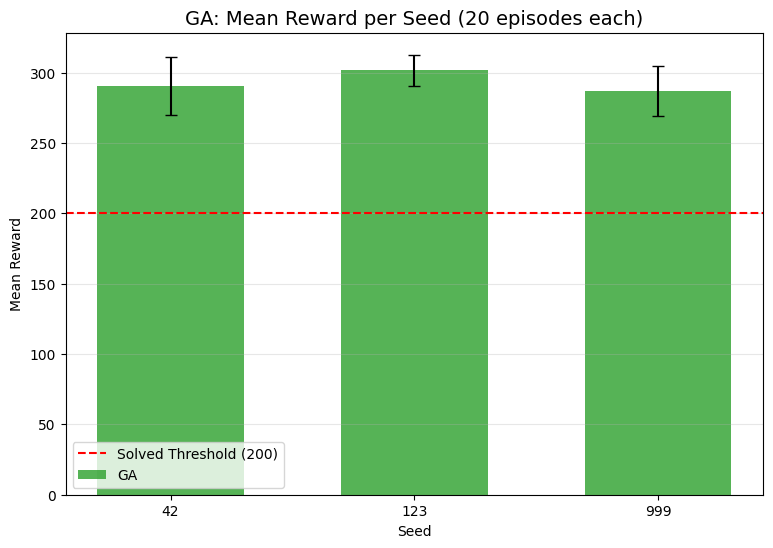

In [15]:
# Evaluation Bar Chart

n_seeds = len(SEED_LIST)
x = np.arange(n_seeds)

means = [np.mean(evaluation_results[s]) for s in SEED_LIST]
stds = [np.std(evaluation_results[s]) for s in SEED_LIST]

plt.figure(figsize=(max(8, 3 * n_seeds), 6))
plt.bar(x, means, 0.6, yerr=stds, capsize=4, label='GA', alpha=0.8, color='tab:green')
plt.axhline(y=200, color='red', linestyle='--', label='Solved Threshold (200)')
plt.xticks(x, [str(s) for s in SEED_LIST])
plt.title(f"GA: Mean Reward per Seed ({EVALUATION_EPISODES} episodes each)", fontsize=14)
plt.xlabel("Seed")
plt.ylabel("Mean Reward")
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.show()

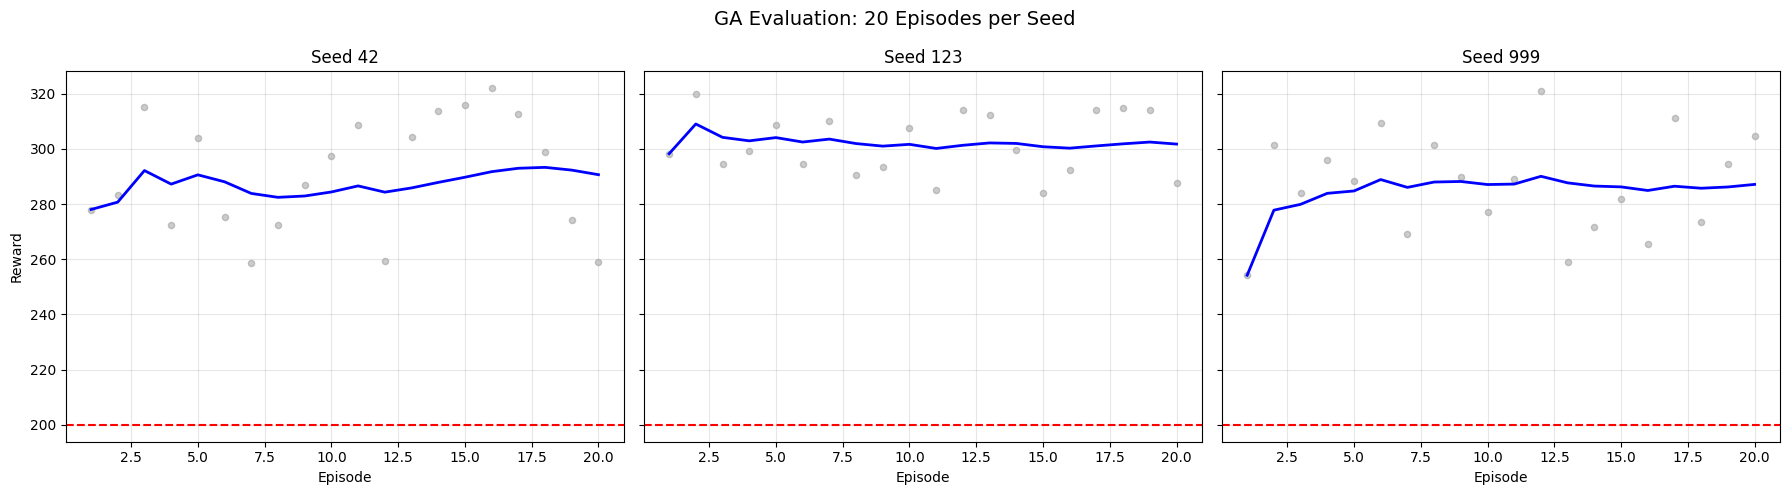

In [16]:
# Evaluation Convergence Plots (per seed)

fig, axes = plt.subplots(1, len(SEED_LIST), figsize=(6 * len(SEED_LIST), 5), sharey=True)
if len(SEED_LIST) == 1:
    axes = [axes]

for ax, seed in zip(axes, SEED_LIST):
    rewards = evaluation_results[seed]
    episodes = np.arange(1, len(rewards) + 1)
    running_mean = np.cumsum(rewards) / episodes

    ax.scatter(episodes, rewards, color='gray', alpha=0.4, s=20)
    ax.plot(episodes, running_mean, color='blue', linewidth=2)
    ax.axhline(y=200, color='red', linestyle='--')
    ax.set_title(f"Seed {seed}")
    ax.set_xlabel("Episode")
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel("Reward")
fig.suptitle(f"GA Evaluation: {EVALUATION_EPISODES} Episodes per Seed", fontsize=14)
plt.tight_layout()
plt.show()

Generating GIF for GA seed 42 (best genome)...
  Saved: /home/logus/env/iscte/taap_p2/genetic/outputs_ga/ga_seed42.gif


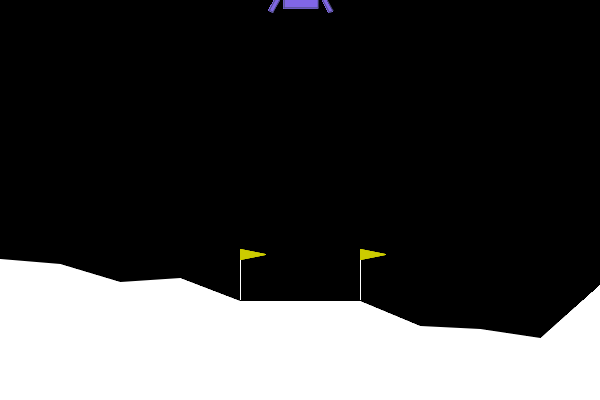

Generating GIF for GA seed 123 (best genome)...
  Saved: /home/logus/env/iscte/taap_p2/genetic/outputs_ga/ga_seed123.gif


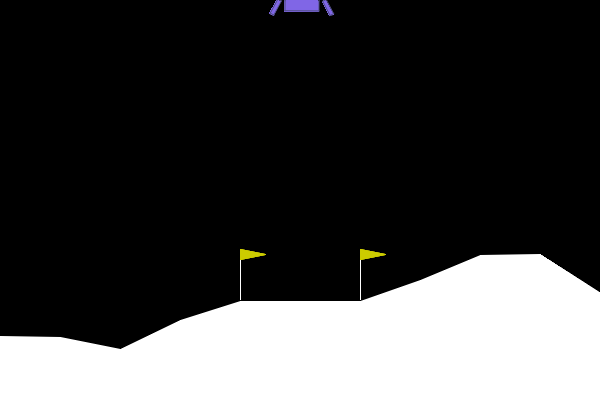

Generating GIF for GA seed 999 (best genome)...
  Saved: /home/logus/env/iscte/taap_p2/genetic/outputs_ga/ga_seed999.gif


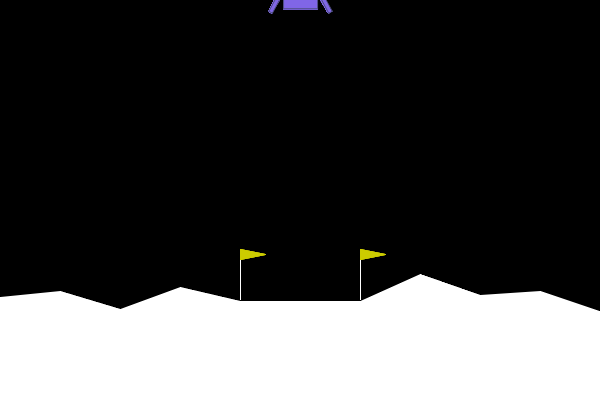

In [17]:
# GIF Visualization (one per seed, best genome)

output_dir = os.path.join(NOTEBOOK_DIR, "outputs_ga")
os.makedirs(output_dir, exist_ok=True)

for seed in SEED_LIST:
    print(f"Generating GIF for GA seed {seed} (best genome)...")

    gif_path = os.path.join(output_dir, f"ga_seed{seed}.gif")
    record_genome_gif(best_genomes[seed], seed, gif_path)

    print(f"  Saved: {gif_path}")
    display(Image(filename=gif_path))

In [18]:
# Hyperparameter Table

params = {
    "input_size": INPUT_SIZE,
    "hidden1_size": HIDDEN1_SIZE,
    "hidden2_size": HIDDEN2_SIZE,
    "output_size": OUTPUT_SIZE,
    "population_size": POPULATION_SIZE,
    "mutation_rate": MUTATION_RATE,
    "generations": GENERATIONS,
    "eval_seeds_per_generation": EVAL_SEEDS_PER_GEN,
    "elitism": 3,
    "parent_selection": "top 20%",
    "crossover": "uniform gene-wise",
    "mutation": "Gaussian (clipped +/-0.1)",
    "activation": "tanh (hidden), linear (output)",
    "max_workers": MAX_WORKERS,
}

rows = [{"Parameter": k, "Value": str(v)} for k, v in params.items()]

print("*** GA Hyperparameters ***")
print(pd.DataFrame(rows).to_string(index=False))

*** GA Hyperparameters ***
                Parameter                          Value
               input_size                              8
             hidden1_size                             10
             hidden2_size                             10
              output_size                              4
          population_size                             50
            mutation_rate                           0.05
              generations                           5000
eval_seeds_per_generation                              3
                  elitism                              3
         parent_selection                        top 20%
                crossover              uniform gene-wise
                 mutation      Gaussian (clipped +/-0.1)
               activation tanh (hidden), linear (output)
              max_workers                             20
